In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi
from matplotlib import pyplot as plt

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
SCRNA_DIR = '../data/chen-2019/AdBrainCortex/rna/'
SCATAC_DIR = '../data/chen-2019/AdBrainCortex/atac/'
META_PATH = '../data/chen-2019/AdBrainCortex/AdBrainCortex.csv'

# MetaData

In [4]:
metadata = pd.read_csv(META_PATH, index_col=0)
metadata.head()

Batch       Barcode       Ident
09A_CAGCCCCGCCTT   09A  CAGCCCCGCCTT      E3Rorb
09A_CGCCTACCATGA   09A  CGCCTACCATGA     E5Parm1
09A_GATGCGCGGCTA   09A  GATGCGCGGCTA         Ast
09A_GGTCCGAGTCCT   09A  GGTCCGAGTCCT  E4Il1rapl2
09A_TCTCCCGGCACC   09A  TCTCCCGGCACC     E5Parm1

# scRNA-seq Data

In [5]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_symbols', cache=True)
scrna.obs = scrna.obs.join(metadata, how='left', sort=False)
scrna

CPU times: user 676 ms, sys: 76 ms, total: 752 ms
Wall time: 750 ms


AnnData object with n_obs × n_vars = 10309 × 33160
    obs: 'Batch', 'Barcode', 'Ident'
    var: 'gene_ids'

In [6]:
scrna.obs.head()

Batch       Barcode       Ident
09A_CAGCCCCGCCTT   09A  CAGCCCCGCCTT      E3Rorb
09A_CGCCTACCATGA   09A  CGCCTACCATGA     E5Parm1
09A_GATGCGCGGCTA   09A  GATGCGCGGCTA         Ast
09A_GGTCCGAGTCCT   09A  GGTCCGAGTCCT  E4Il1rapl2
09A_TCTCCCGGCACC   09A  TCTCCCGGCACC     E5Parm1

In [7]:
scrna.var.head()

gene_ids
0610005C13Rik  0610005C13Rik
0610007P14Rik  0610007P14Rik
0610009B22Rik  0610009B22Rik
0610009E02Rik  0610009E02Rik
0610009L18Rik  0610009L18Rik

## Data Cleaning

In [8]:
scrna.obs = scrna.obs.rename(columns={'Ident': 'cell_type'})

In [9]:
scrna.obs['Batch'] = scrna.obs['Batch'].astype('category')
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [10]:
scrna.var = scrna.var.rename(columns={'gene_ids': 'gene_symbols'})

## Quality Control

In [11]:
scrna.var_names_make_unique()

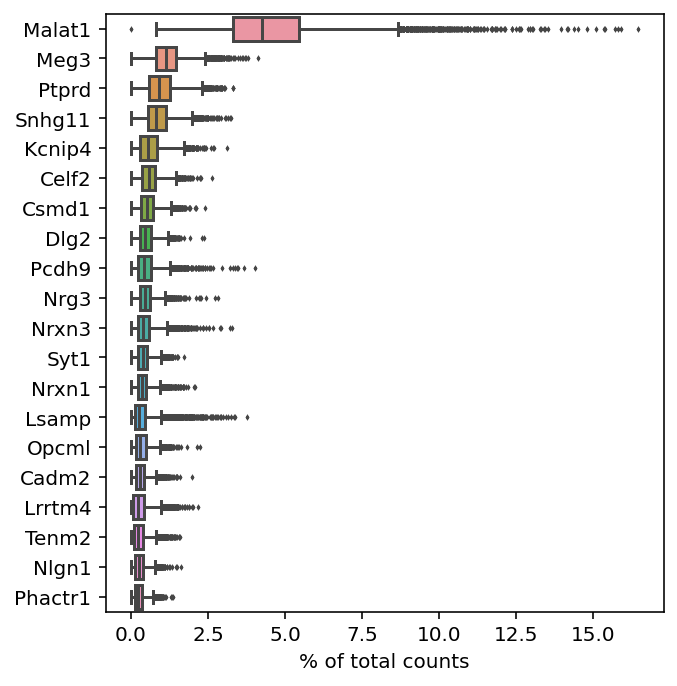

In [12]:
sc.pl.highest_expr_genes(scrna, n_top=20)

### Basic filtering

In [13]:
sc.pp.filter_cells(scrna, min_genes=1)
sc.pp.filter_genes(scrna, min_cells=1)
scrna

AnnData object with n_obs × n_vars = 10309 × 31367
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes'
    var: 'gene_symbols', 'n_cells'

Save the raw data:

In [14]:
scrna.raw = scrna

### Qalculate QC metrics including Mitochondrial genes

In [15]:
scrna.var['mt'] = scrna.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 10309 × 31367
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'Barcode' as categorical


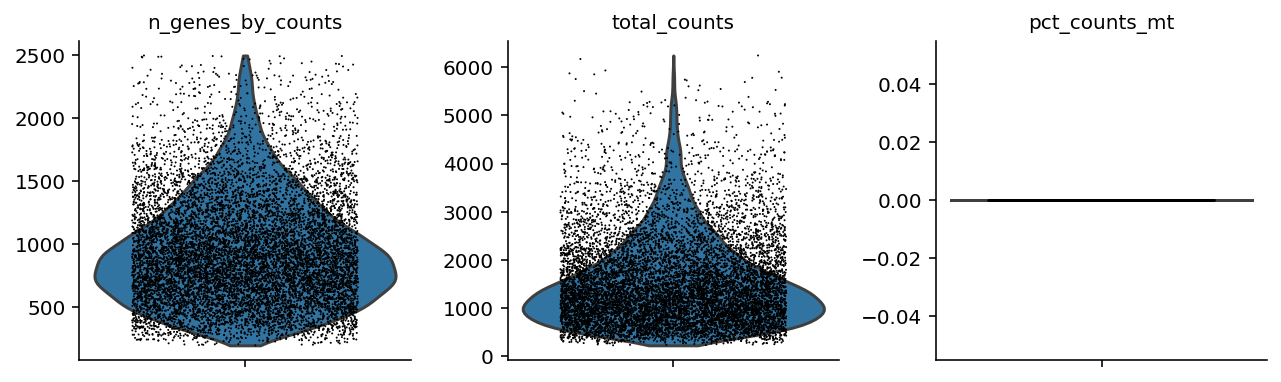

In [16]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

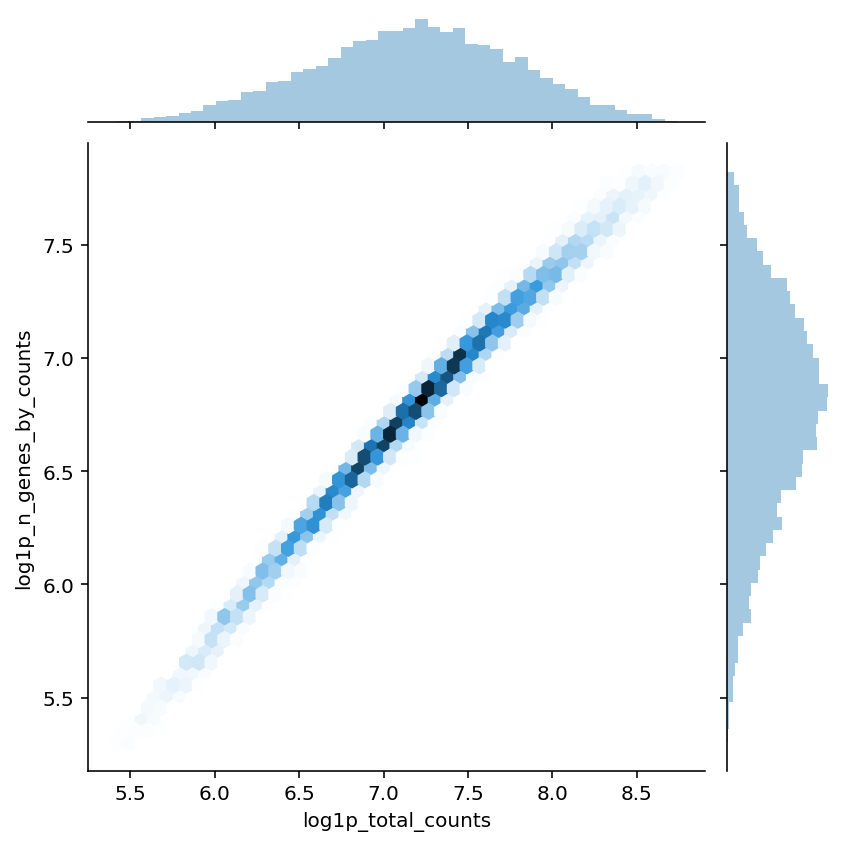

In [17]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna.obs, kind='hex');

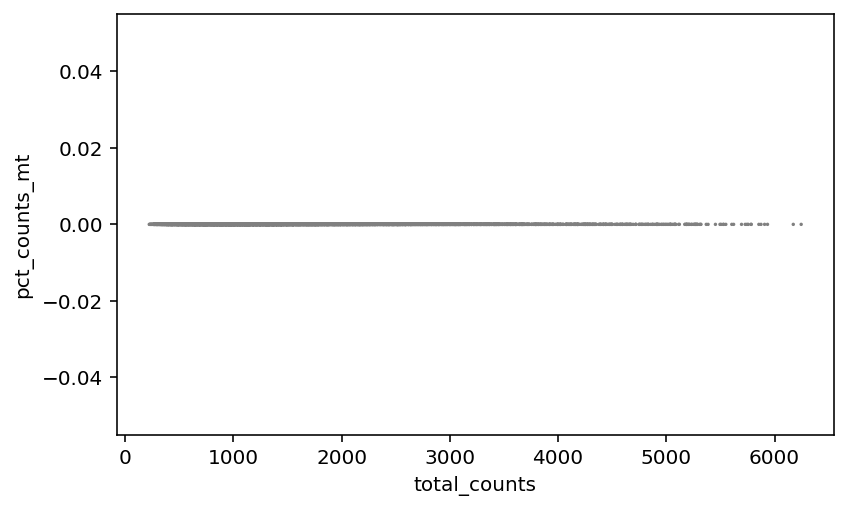

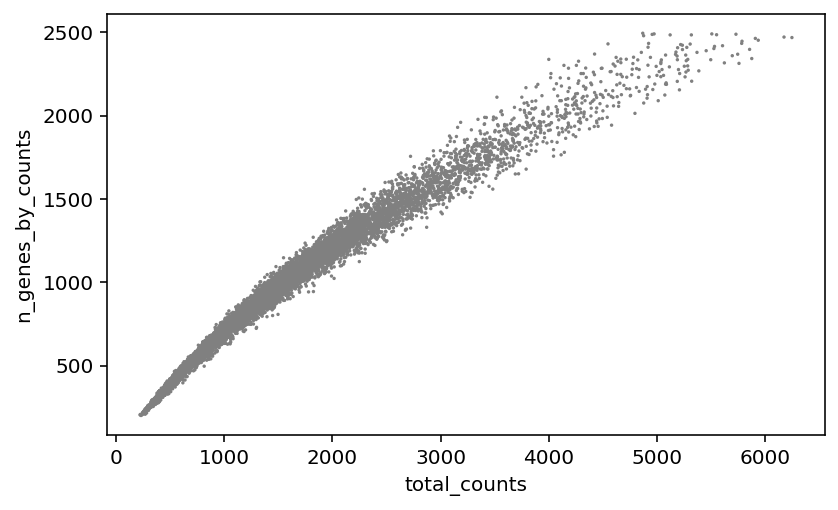

In [18]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

No mitochondrial samples! Good! 
Filter out samples with too low and too high number of genes.
Also filter out samples with low number of cells:

In [19]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna = scrna[scrna.obs.n_genes_by_counts < 2200, :]
scrna

View of AnnData object with n_obs × n_vars = 10200 × 25403
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization

In [20]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

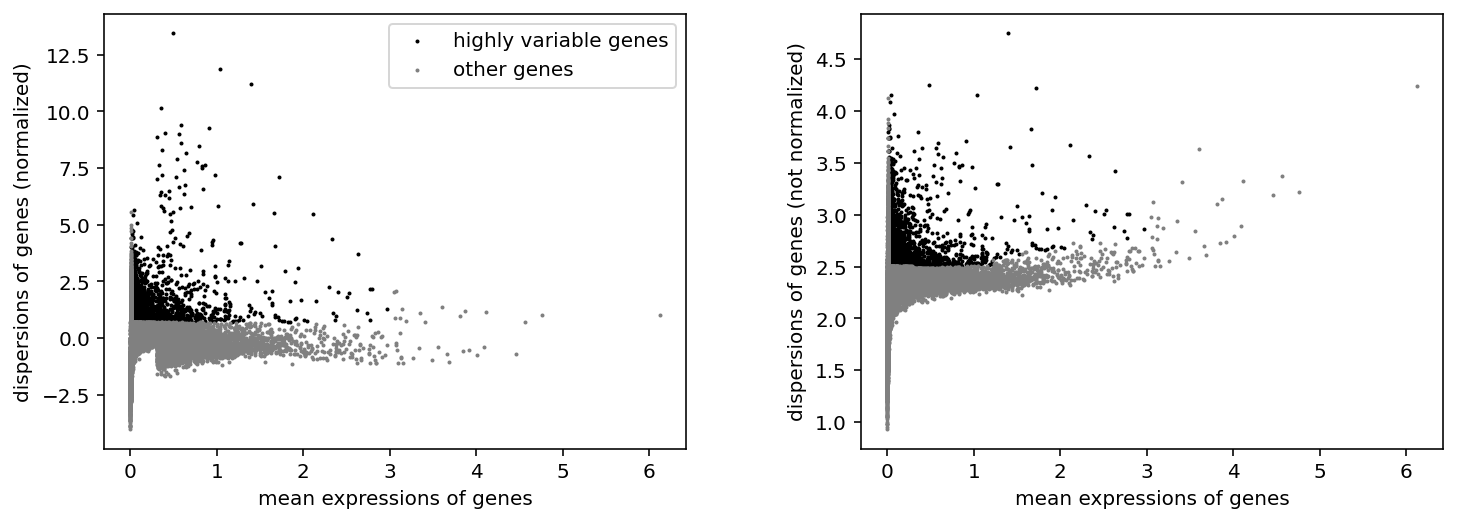

number of highly variable genes = 2967


In [21]:
sc.pp.highly_variable_genes(scrna, min_mean=0.0125, max_mean=3, min_disp=0.7)
sc.pl.highly_variable_genes(scrna)
print('number of highly variable genes =', scrna.var.highly_variable.sum())

In [22]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 10200 × 2967
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Visualization

In [23]:
sc.pp.neighbors(scrna)
sc.tl.umap(scrna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


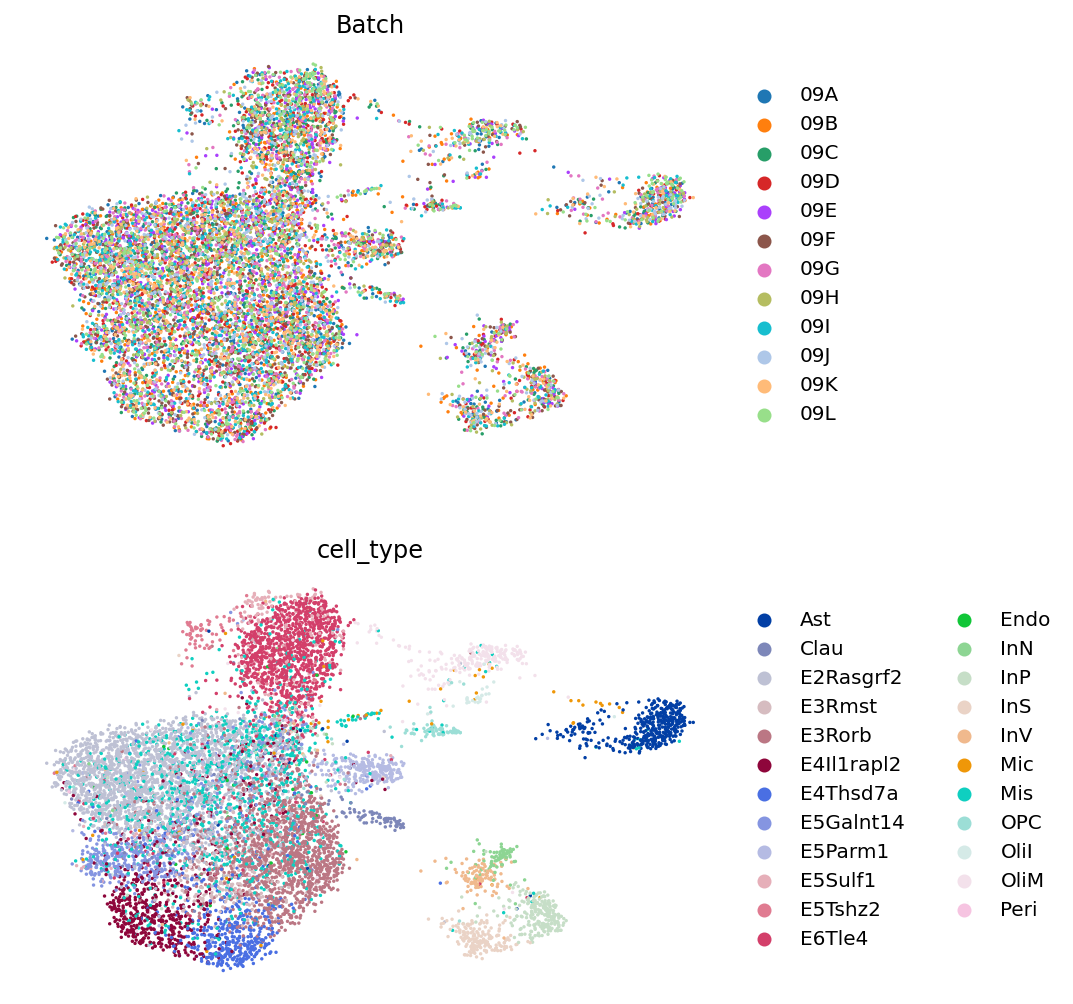

In [24]:
sc.pl.umap(scrna, color=['Batch', 'cell_type'], frameon=False, ncols=1)

---
# scATAC-seq Data

In [25]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_symbols', cache=True)
scatac.obs = scatac.obs.join(metadata, how='left', sort=False)
scatac

CPU times: user 2.13 s, sys: 200 ms, total: 2.33 s
Wall time: 2.89 s


AnnData object with n_obs × n_vars = 10309 × 244544
    obs: 'Batch', 'Barcode', 'Ident'
    var: 'gene_ids'

In [26]:
scatac.obs.head()

Batch       Barcode Ident
09A_GATGCGCGGCTA   09A  GATGCGCGGCTA   Ast
09A_GCCATGACCCCA   09A  GCCATGACCCCA   Ast
09F_TGGACGATTTGT   09F  TGGACGATTTGT   Ast
09K_GTCTGCCATTAC   09K  GTCTGCCATTAC   Ast
09F_GGATGAAGAGGG   09F  GGATGAAGAGGG   Ast

In [27]:
scatac.var.head()

gene_ids
chr1:3005833-3005982  chr1:3005833-3005982
chr1:3094772-3095489  chr1:3094772-3095489
chr1:3119556-3120739  chr1:3119556-3120739
chr1:3121334-3121696  chr1:3121334-3121696
chr1:3134637-3135032  chr1:3134637-3135032

## Data Cleaning

In [28]:
scatac.obs = scatac.obs.rename(columns={'Ident': 'cell_type'})

In [29]:
scatac.obs['Batch'] = scatac.obs['Batch'].astype('category')
scatac.obs['cell_type'] = scatac.obs['cell_type'].astype('category')

## Quality Control

### Basic filtering

In [30]:
epi.pp.filter_features(scatac, min_cells=1)
epi.pp.filter_cells(scatac, min_features=1)
scatac

AnnData object with n_obs × n_vars = 10309 × 244538
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells'

Save the raw data:

In [31]:
scatac.raw = scatac

## Visualization of the raw data

In [32]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'Barcode' as categorical


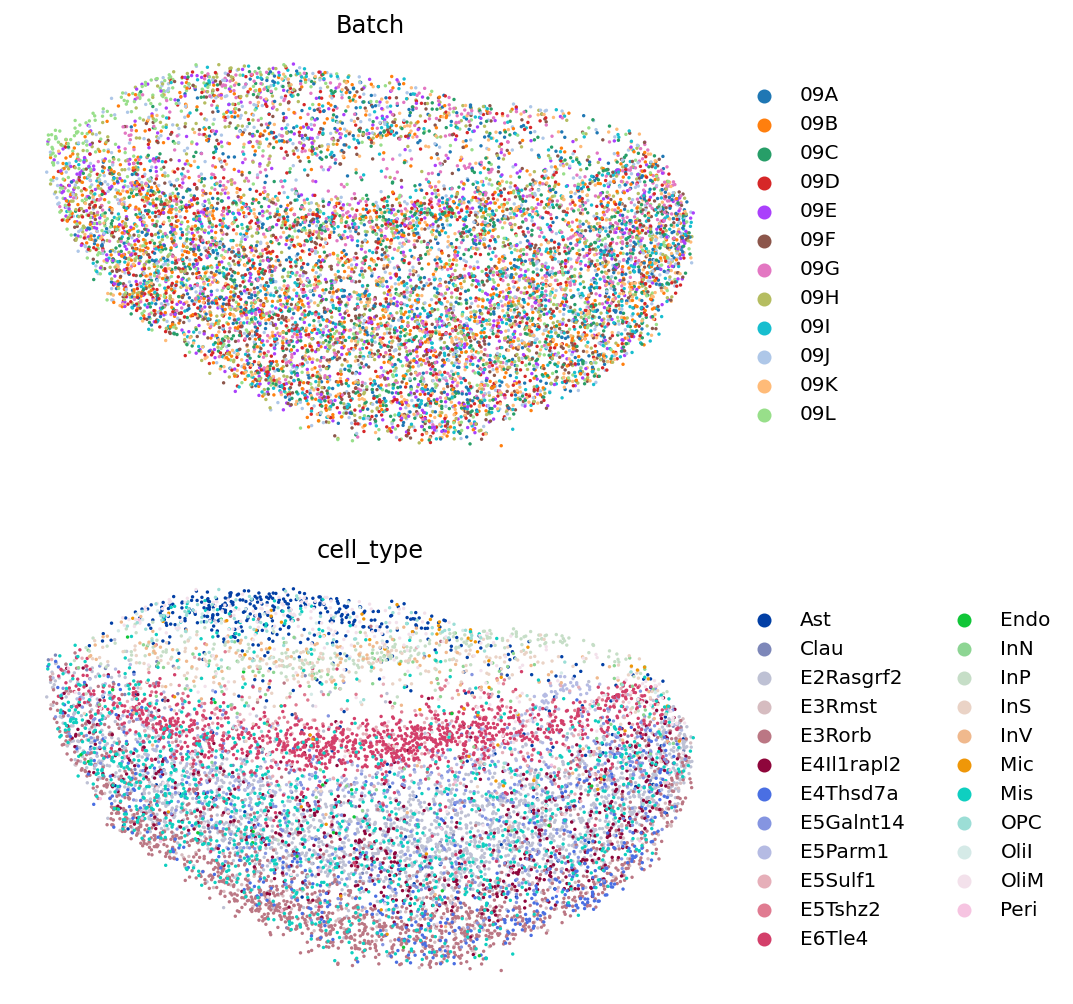

In [33]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], frameon=False, ncols=1)

## Binarization

In [34]:
%time scatac = epi.pp.binarize(scatac, copy=True)
scatac

CPU times: user 2.16 s, sys: 380 ms, total: 2.54 s
Wall time: 2.54 s


AnnData object with n_obs × n_vars = 10309 × 244538
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

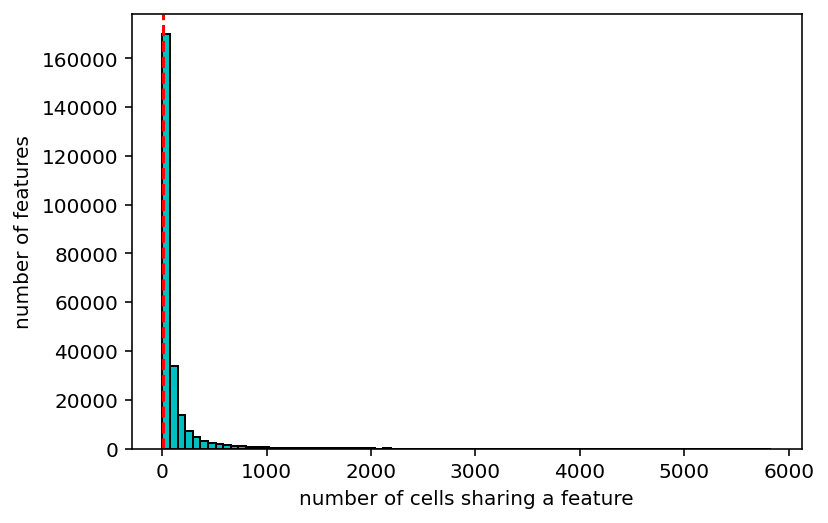

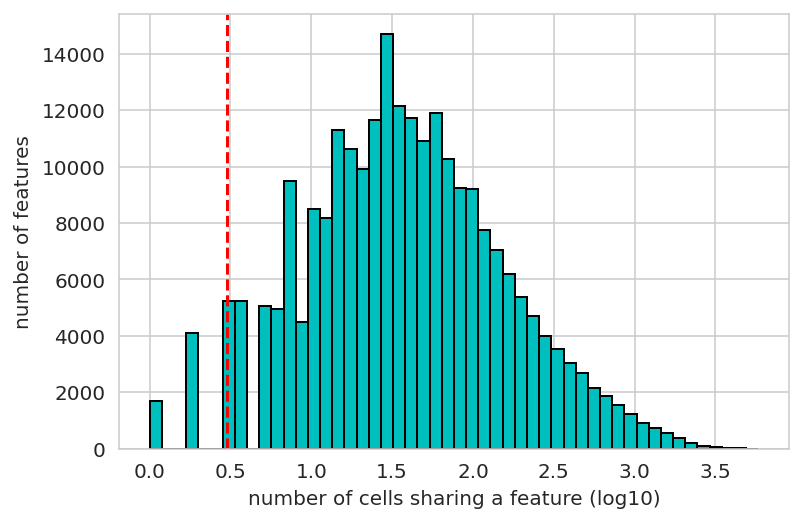

In [35]:
epi.pp.coverage_features(scatac, binary=True, log=False, threshold=3)
epi.pp.coverage_features(scatac, binary=True, log=True, threshold=3)

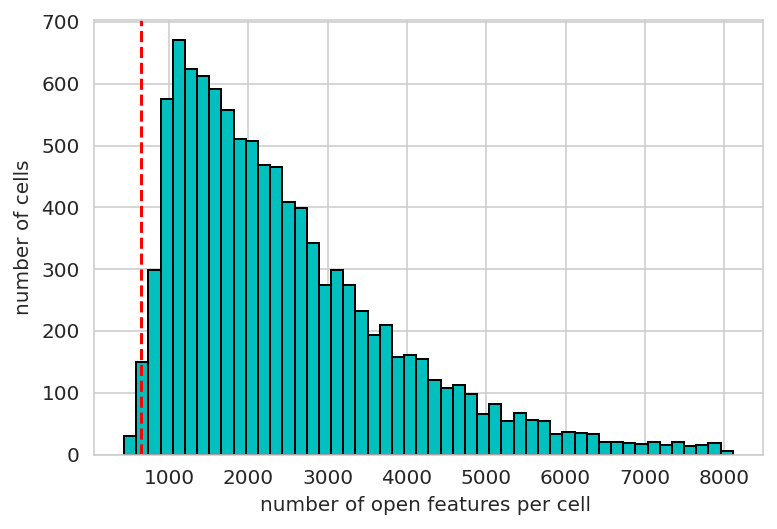

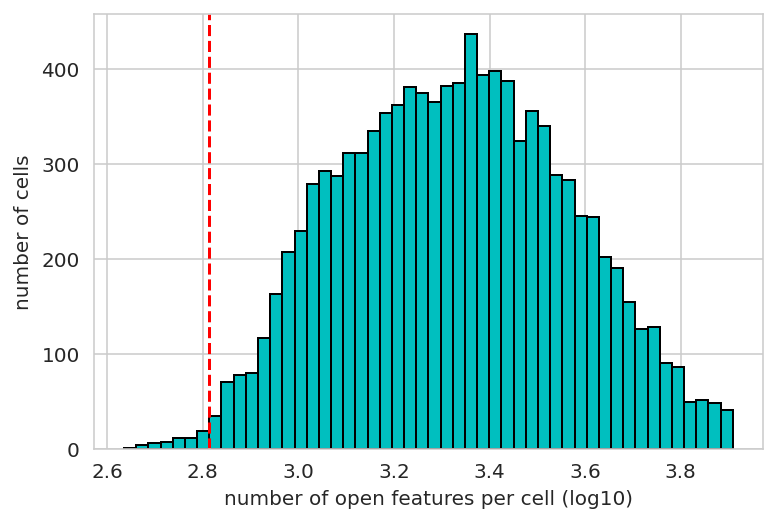

In [36]:
epi.pp.coverage_cells(scatac, binary=True, log=False, threshold=650)
epi.pp.coverage_cells(scatac, binary=True, log=True, threshold=650)

## Visualization of the raw binary data

In [37]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

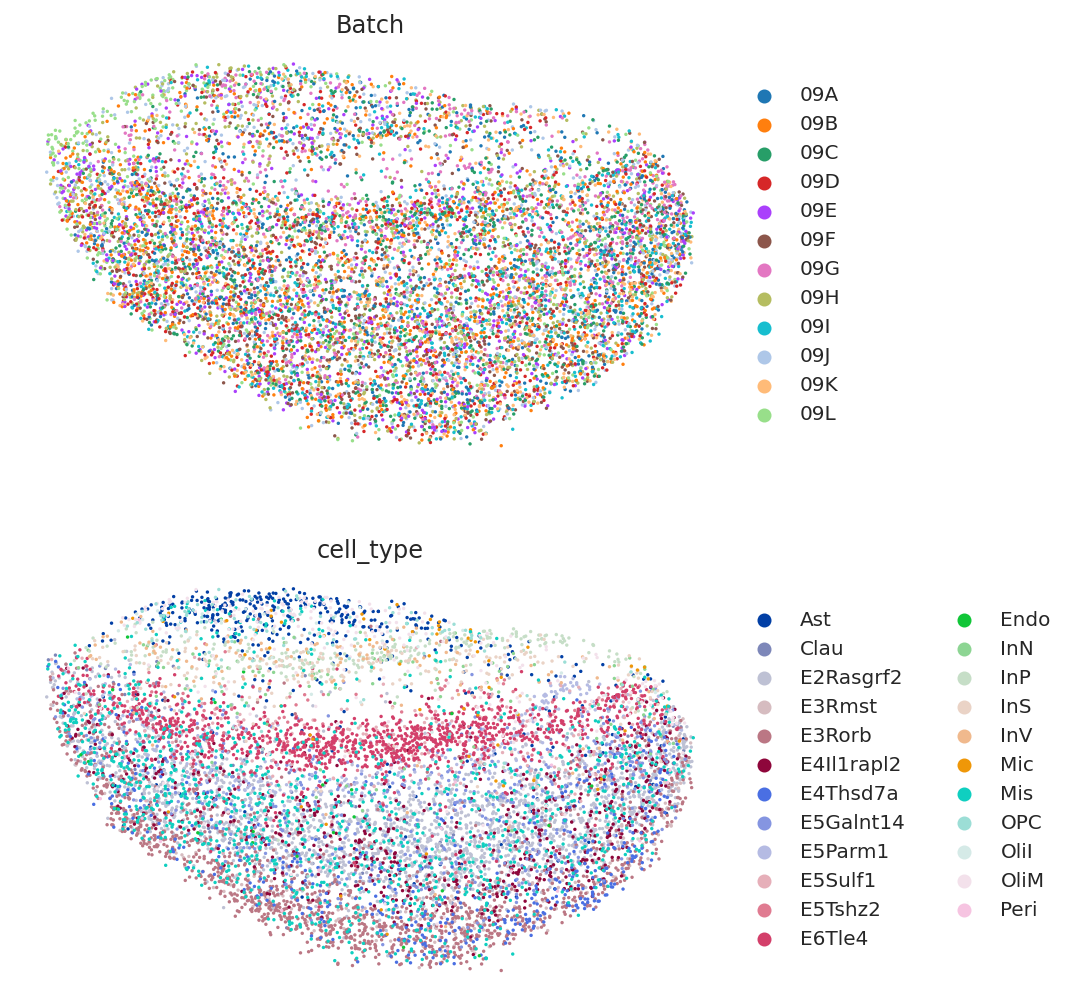

In [38]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], frameon=False, ncols=1)

## Filter low quality cells and peaks

In [39]:
epi.pp.filter_cells(scatac, min_features=650)
epi.pp.filter_features(scatac, min_cells=3)
scatac

AnnData object with n_obs × n_vars = 10252 × 238693
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [40]:
scatac.obs['nb_features'].describe()

count    10252.000000
mean      2480.427624
std       1391.371473
min        651.000000
25%       1426.000000
50%       2141.000000
75%       3175.000000
max       8110.000000
Name: nb_features, dtype: float64

In [41]:
scatac.var['commonness'].describe()

count    238693.000000
mean        106.630039
std         221.276390
min           3.000000
25%          16.000000
50%          37.000000
75%          97.000000
max        5832.000000
Name: commonness, dtype: float64

In [42]:
scatac.var['commonness'].median()

37.0

In [43]:
scatac = scatac[:, scatac.var['commonness'] > 37]
scatac

View of AnnData object with n_obs × n_vars = 10252 × 119069
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Selecting variable peaks

Trying to set attribute `.var` of view, copying.


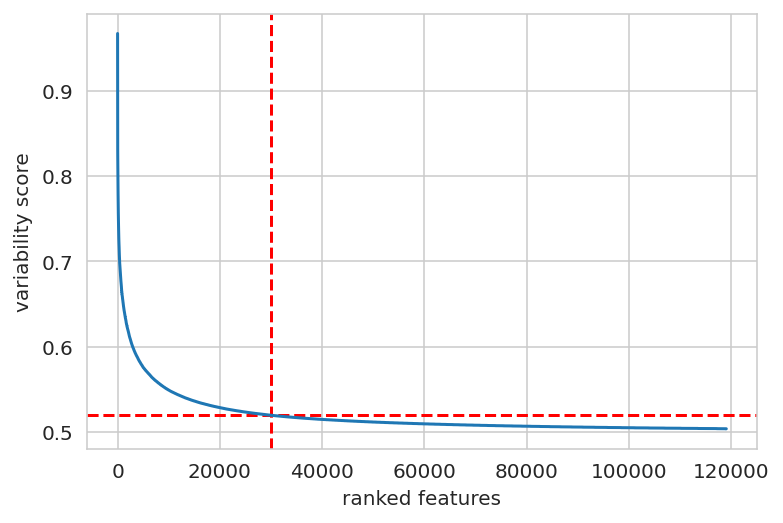

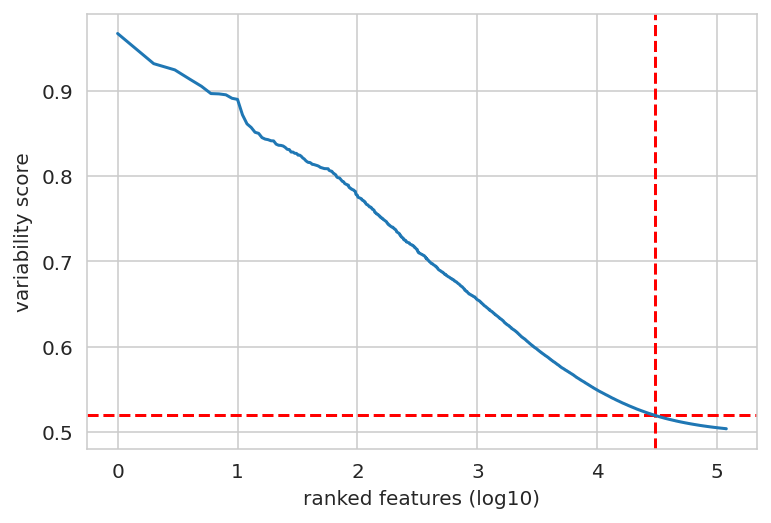

In [44]:
min_score_value = 0.52
nb_feature_selected = 30000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

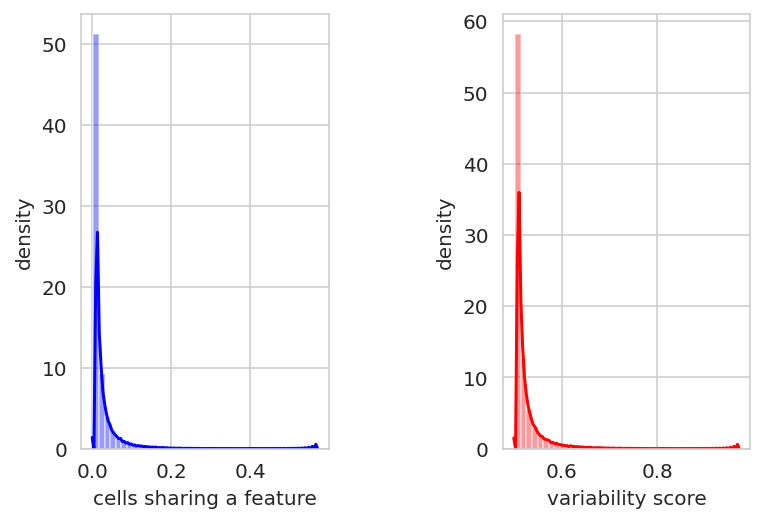

CPU times: user 1.69 s, sys: 2.93 s, total: 4.62 s
Wall time: 5.54 s


In [45]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True, show=True)

In [46]:
scatac

View of AnnData object with n_obs × n_vars = 10252 × 30104
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Visualization

### Running UMAP

In [47]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

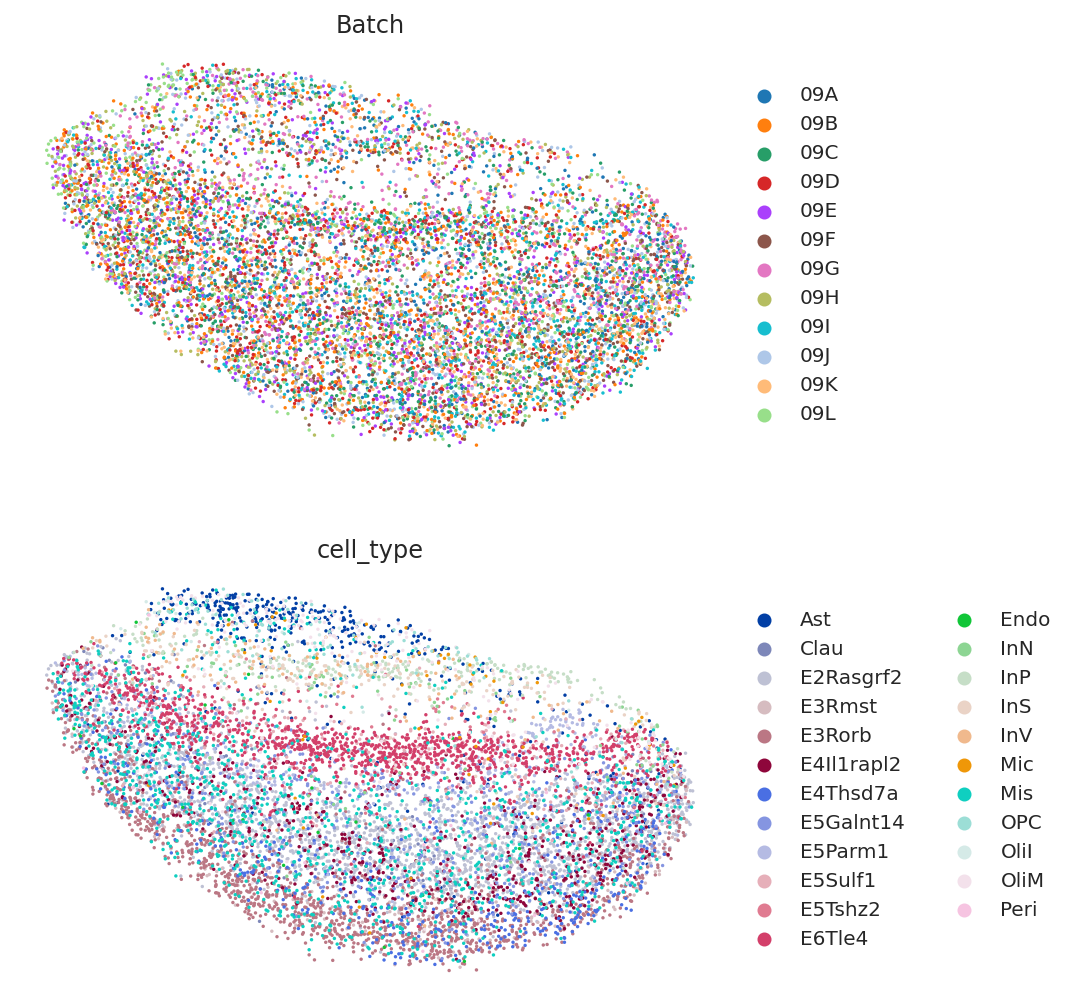

In [48]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], frameon=False, ncols=1)

---
# Save the results

### Find common paired samples

In [49]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(10143, 2967) (10143, 30104)


In [50]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 392 ms, sys: 156 ms, total: 548 ms
Wall time: 1.33 s


In [51]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

CPU times: user 3.51 s, sys: 376 ms, total: 3.88 s
Wall time: 4.08 s
